In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb
from catboost import CatBoostRegressor

In [3]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [7]:
data = pd.read_csv("merged_data/6_with_climate_filled.csv")
data.head()

,grower,field,year,lat,lng,cpba_count,cpbl_count,tmin,tmax,gdd,...,intensity,potato_proportion,tmin_annual,tmax_annual,annual_prcp,summer_tmin,summer_avg,summer_prcp,winter_avg,winter_tmax
0,Wisconsin Central Farms,1 Necedah,2014,44.057164,-90.040412,3.307692,3.900000,44.815974,83.173633,13.772113,...,0.069034,0.4,-30.9,31.0,3.098630,-4.7,18.290083,3.366667,-12.111905,7.0
1,Wisconsin Central Farms,13 Nepco N 1/2,2014,44.209406,-90.021382,4.562500,8.714286,45.498328,79.713370,12.804045,...,0.034770,0.2,-31.1,31.1,1.244492,-1.1,18.627049,1.473810,-12.090588,6.1
2,Wisconsin Central Farms,16 13th St,2014,44.100775,-90.050524,1.637500,2.190000,45.224964,82.761841,14.263578,...,0.103131,0.4,-30.9,31.0,1.244492,-4.7,18.342276,1.473810,-11.597778,7.0
3,Wisconsin Central Farms,26 Huebner,2014,44.171606,-89.975877,2.181818,4.555556,45.584387,82.216665,13.292737,...,0.068644,0.4,-31.1,31.1,1.244492,-1.1,18.633333,1.473810,-12.063333,6.1
4,Wisconsin Central Farms,7 N Home,2014,44.329762,-89.931300,1.200000,5.500000,45.715179,78.727568,12.237354,...,0.034145,0.4,-31.1,31.1,1.244492,-1.1,18.627049,1.473810,-12.090588,6.1


In [9]:
data.shape

(4287, 22)

In [11]:
data.isnull().sum()

grower                  0
field                   0
year                    0
lat                     0
lng                     0
cpba_count              0
cpbl_count              0
tmin                 1247
tmax                 1247
gdd                  1247
cum_gdd              1247
crop_type               0
intensity               0
potato_proportion       0
tmin_annual             0
tmax_annual             0
annual_prcp             0
summer_tmin             0
summer_avg              0
summer_prcp             0
winter_avg              0
winter_tmax             0
dtype: int64

In [13]:
columns_to_drop = ['grower', 'field', 'lat', 'lng','year']
data = data.drop(columns = columns_to_drop, errors = 'ignore')

data['y1'] = data['cpba_count']  # Response y1
data['y2'] = (data['cpba_count'] + data['cpbl_count']) / 2  # Response y2

X = data.drop(columns = ['cpba_count', 'cpbl_count', 'y1', 'y2'])
y = data['y2']

X2 = X.drop(columns=['tmin', 'tmax', 'gdd', 'cum_gdd'])

### Testing for Correlation using HeatMAP

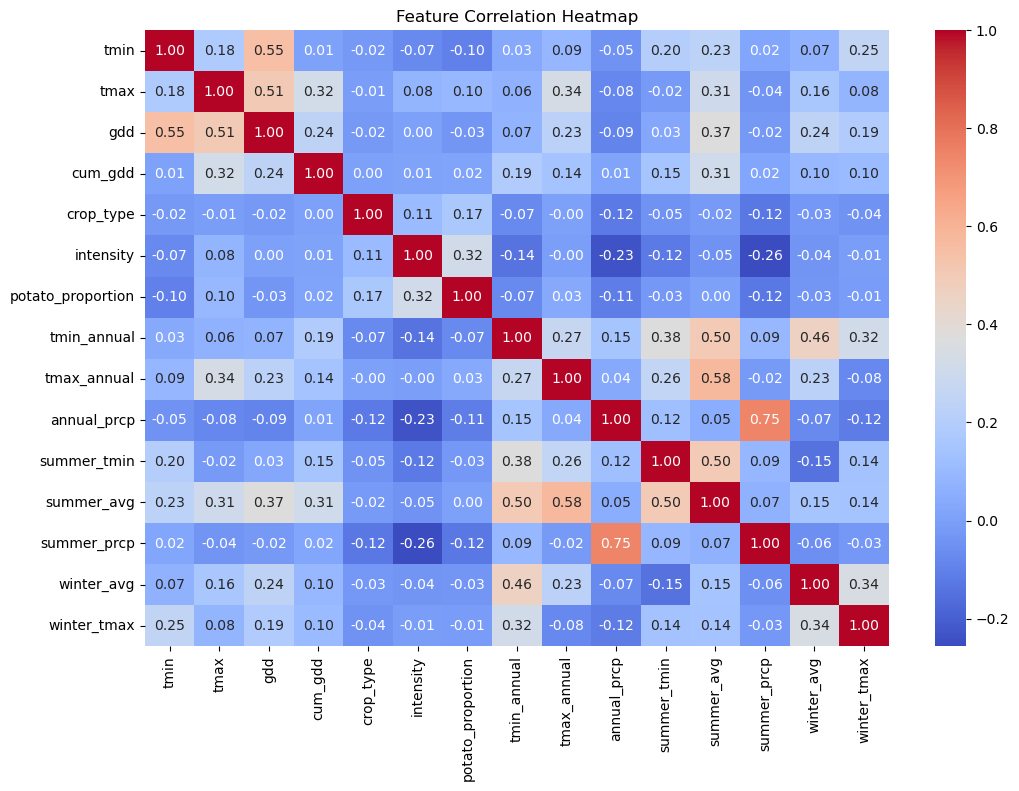

In [16]:
corr_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

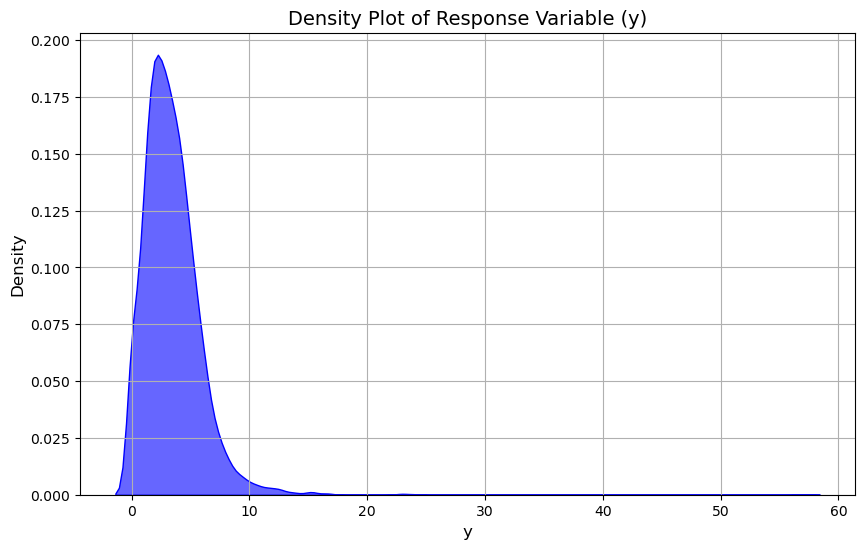

In [18]:
X, X2 = X.drop(columns = ['annual_prcp']), X2.drop(columns = ['annual_prcp'])
plt.figure(figsize=(10, 6)) 
sns.kdeplot(data['y2'], fill=True, color='blue', alpha=0.6)

plt.title('Density Plot of Response Variable (y)', fontsize=14)
plt.xlabel('y', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.grid(True)  
plt.show()

In [20]:
X1_train, X1_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X2_train, X2_test, y_train, y_test = train_test_split (X2, y, test_size = 0.2, random_state = 42)

In [22]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    
    # Feature Importance (if available)
    if hasattr(model, "feature_importances_"):
        feature_importance = model.feature_importances_
        print("Feature Importance:")
        for name, importance in zip(X_train.columns, feature_importance):
            print(f"{name}: {importance:.4f}")
    
    print("\n")
    return mse, r2

In [24]:
# Import additional models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Models for X1 (with missing values, handled directly by robust models)
models_X1 = [
    #RandomForestRegressor(random_state=42),
    XGBRegressor(random_state=42),
    #KNeighborsRegressor(),
    #GradientBoostingRegressor(random_state=42),
    #SVR()
    lgb.LGBMRegressor(random_state=42),
]

# Models for X2 (no missing values)
models_X2 = [
    LinearRegression(),
   # DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    XGBRegressor(random_state=42),
    KNeighborsRegressor(),
    GradientBoostingRegressor(random_state=42),
    lgb.LGBMRegressor(random_state=42),
   # CatBoostRegressor(verbose=0, random_state=42),  # Silent training
   # SVR()
]

# Models for X3 (filled missing values)
models_X3 = [
    #LinearRegression(),
    #DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    #XGBRegressor(random_state=42),
    #KNeighborsRegressor(),
    GradientBoostingRegressor(random_state=42),
    lgb.LGBMRegressor(random_state=42),
    # Additional models can be added here
]

### Modeling for X1 (with missing values)

In [27]:
print("Modeling for X1 (Missing Values Supported):")
for model in models_X1:
    train_and_evaluate(model, X1_train, X1_test, y_train, y_test)


Modeling for X1 (Missing Values Supported):
Model: XGBRegressor
Mean Squared Error: 6.1794
R2 Score: -0.1649
Feature Importance:
tmin: 0.0443
tmax: 0.0439
gdd: 0.0302
cum_gdd: 0.0605
crop_type: 0.1155
intensity: 0.0364
potato_proportion: 0.0432
tmin_annual: 0.0875
tmax_annual: 0.0417
summer_tmin: 0.0531
summer_avg: 0.0586
summer_prcp: 0.0428
winter_avg: 0.0571
winter_tmax: 0.2852


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 3429, number of used features: 14
[LightGBM] [Info] Start training from score 3.377282
Model: LGBMRegressor
Mean Squared Error: 3.5965
R2 Score: 0.3220
Feature Importance:
tmin: 312.0000
tmax: 357.0000
gdd: 315.0000
cum_gdd: 400.0000
crop_type: 85.0000
intensity: 447.0000
potato_proportion: 69.00

### Modeling without Missing values (Dropped)

In [30]:
print("\nModeling for X2 (No Missing Values):")
for model in models_X2:
    train_and_evaluate(model, X2_train, X2_test, y_train, y_test)


Modeling for X2 (No Missing Values):
Model: LinearRegression
Mean Squared Error: 4.7052
R2 Score: 0.1131


Model: RandomForestRegressor
Mean Squared Error: 4.0105
R2 Score: 0.2440
Feature Importance:
crop_type: 0.0724
intensity: 0.4552
potato_proportion: 0.0739
tmin_annual: 0.0592
tmax_annual: 0.0308
summer_tmin: 0.0279
summer_avg: 0.0754
summer_prcp: 0.0538
winter_avg: 0.0410
winter_tmax: 0.1102


Model: XGBRegressor
Mean Squared Error: 3.9759
R2 Score: 0.2505
Feature Importance:
crop_type: 0.1066
intensity: 0.0600
potato_proportion: 0.0381
tmin_annual: 0.0890
tmax_annual: 0.0669
summer_tmin: 0.0816
summer_avg: 0.0792
summer_prcp: 0.0591
winter_avg: 0.0748
winter_tmax: 0.3447


Model: KNeighborsRegressor
Mean Squared Error: 4.1884
R2 Score: 0.2105


Model: GradientBoostingRegressor
Mean Squared Error: 3.9168
R2 Score: 0.2617
Feature Importance:
crop_type: 0.1008
intensity: 0.2948
potato_proportion: 0.0351
tmin_annual: 0.1133
tmax_annual: 0.0326
summer_tmin: 0.0355
summer_avg: 0.0719


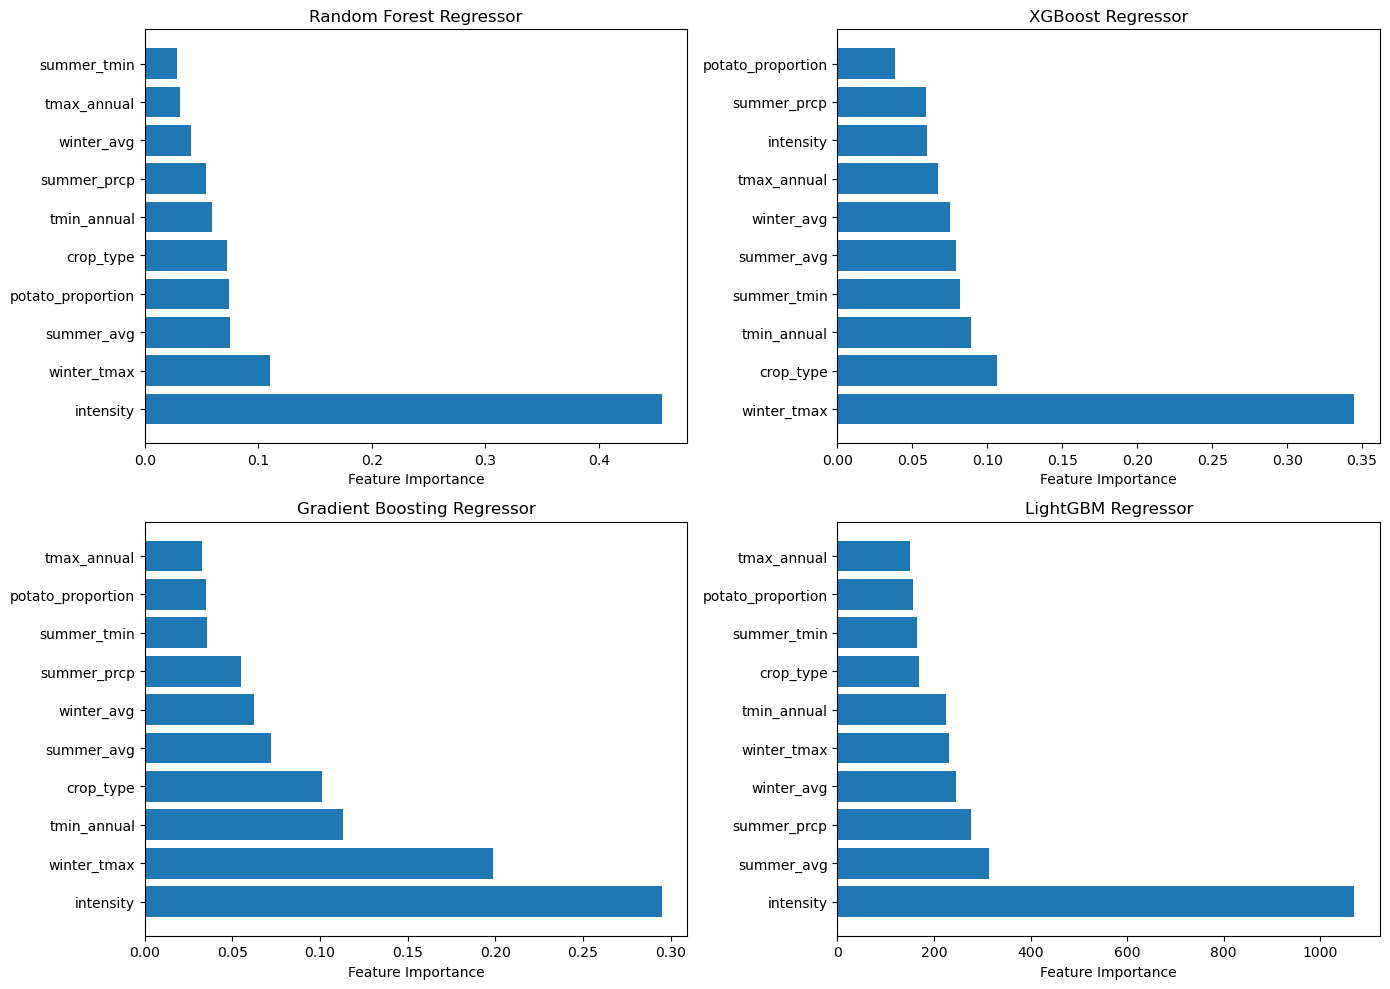

In [32]:
feature_names = [
    'crop_type', 'intensity', 'potato_proportion', 
    'tmin_annual', 'tmax_annual', 'summer_tmin', 
    'summer_avg', 'summer_prcp', 'winter_avg', 'winter_tmax'
]

rf_importances = [0.0724, 0.4552, 0.0739, 0.0592, 0.0308, 0.0279, 0.0754, 0.0538, 0.0410, 0.1102]
xgb_importances = [0.1066, 0.0600, 0.0381, 0.0890, 0.0669, 0.0816, 0.0792, 0.0591, 0.0748, 0.3447]
gbr_importances = [0.1008, 0.2948, 0.0351, 0.1133, 0.0326, 0.0355, 0.0719, 0.0551, 0.0623, 0.1985]
lgb_importances = [168.0, 1070.0, 157.0, 224.0, 150.0, 164.0, 314.0, 277.0, 245.0, 231.0]

model_names = [
    "Random Forest Regressor",
    "XGBoost Regressor",
    "Gradient Boosting Regressor",
    "LightGBM Regressor"
]

feature_importances = [rf_importances, xgb_importances, gbr_importances, lgb_importances]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, ax in enumerate(axes.flatten()):
    importances = feature_importances[i]
    sorted_idx = np.argsort(importances)[::-1]  # Sort by descending importance
    ax.barh(range(len(importances)), np.array(importances)[sorted_idx], align='center')
    ax.set_yticks(range(len(importances)))
    ax.set_yticklabels(np.array(feature_names)[sorted_idx])
    ax.set_title(model_names[i])
    ax.set_xlabel("Feature Importance")

plt.tight_layout()
plt.show()

### Modeling with imputed values

In [35]:
from sklearn.impute import SimpleImputer

# Fill missing values with mean
imputer = SimpleImputer(strategy='mean')

X3 = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

In [37]:
# Train and evaluate models for X3
print("Modeling for X3 (Filled Missing Values Supported):")
for model in models_X3:
    train_and_evaluate(model, X3_train, X3_test, y_train, y_test)

Modeling for X3 (Filled Missing Values Supported):
Model: RandomForestRegressor
Mean Squared Error: 4.0314
R2 Score: 0.2401
Feature Importance:
tmin: 0.0822
tmax: 0.0756
gdd: 0.0719
cum_gdd: 0.1247
crop_type: 0.0634
intensity: 0.1968
potato_proportion: 0.0365
tmin_annual: 0.0582
tmax_annual: 0.0240
summer_tmin: 0.0234
summer_avg: 0.0594
summer_prcp: 0.0406
winter_avg: 0.0369
winter_tmax: 0.1066


Model: GradientBoostingRegressor
Mean Squared Error: 4.2486
R2 Score: 0.1991
Feature Importance:
tmin: 0.0818
tmax: 0.0655
gdd: 0.0249
cum_gdd: 0.1699
crop_type: 0.0849
intensity: 0.1092
potato_proportion: 0.0045
tmin_annual: 0.1182
tmax_annual: 0.0211
summer_tmin: 0.0205
summer_avg: 0.0603
summer_prcp: 0.0425
winter_avg: 0.0402
winter_tmax: 0.1564


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the trai

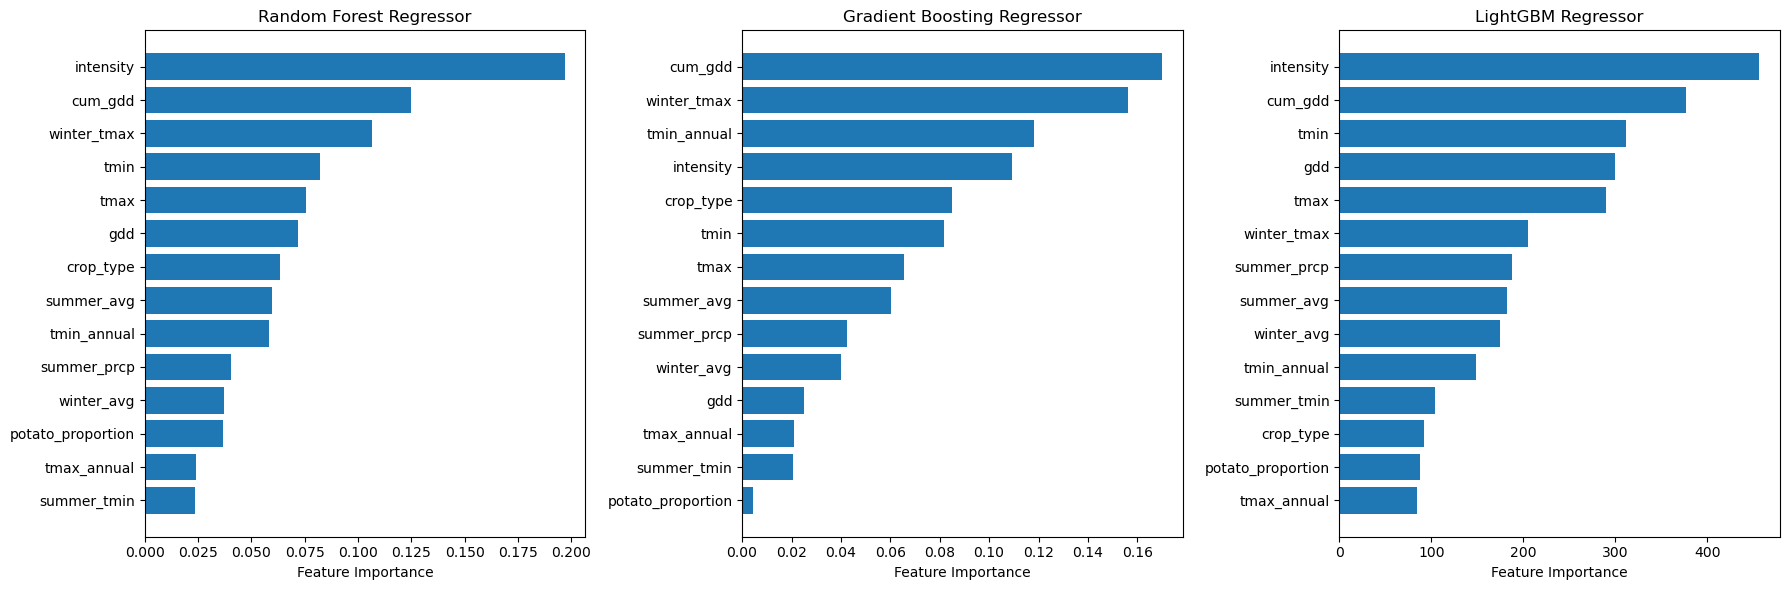

In [39]:
feature_names = [
    'tmin', 'tmax', 'gdd', 'cum_gdd', 'crop_type', 'intensity',
    'potato_proportion', 'tmin_annual', 'tmax_annual',
    'summer_tmin', 'summer_avg', 'summer_prcp', 
    'winter_avg', 'winter_tmax'
]

rf_importances = [0.0822, 0.0756, 0.0719, 0.1247, 0.0634, 0.1968, 0.0365, 0.0582, 0.0240, 0.0234, 0.0594, 0.0406, 0.0369, 0.1066]
gbr_importances = [0.0818, 0.0655, 0.0249, 0.1699, 0.0849, 0.1092, 0.0045, 0.1182, 0.0211, 0.0205, 0.0603, 0.0425, 0.0402, 0.1564]
lgb_importances = [312, 290, 299, 377, 92, 456, 88, 148, 84, 104, 182, 188, 175, 205]

model_names = [
    "Random Forest Regressor",
    "Gradient Boosting Regressor",
    "LightGBM Regressor"
]

feature_importances = [rf_importances, gbr_importances, lgb_importances]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, ax in enumerate(axes):
    importances = feature_importances[i]
    sorted_idx = np.argsort(importances)[::-1]  # Sort by descending importance
    ax.barh(range(len(importances)), np.array(importances)[sorted_idx], align='center')
    ax.set_yticks(range(len(importances)))
    ax.set_yticklabels(np.array(feature_names)[sorted_idx])
    ax.set_title(model_names[i])
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()  # Ensure highest importance is on top

plt.tight_layout()
plt.show()